# Modelos De Regresión

Autor/es:

Benjamín Sepulveda
Aldo Arroyo
Correos Electrónicos:

be.sepulvedat@duocuc.cl
ald.arroyo@duocuc.cl
Fecha de Creación: 15 de Octubre de 2024
Versión: 1.0

# Contexto del negocio

Counter-Strike: Global Offensive (CS: GO) es un videojuego de disparos en primera persona extremadamente popular en la escena de los videojuegos competitivos y los eSports. Se juegan partidas entre dos equipos de 5 jugadores: el equipo de terroristas y el equipo de contra-terroristas. El objetivo principal varía según el rol de los equipos:

Los terroristas deben plantar una bomba en uno de los sitios designados dentro del mapa y defenderla hasta que explote.
Los contra-terroristas deben evitar que la bomba sea plantada o, si es colocada, desactivarla antes de que explote. Una partida se desarrolla a lo largo de varias rondas, y los equipos pueden ganar una ronda eliminando al equipo contrario o cumpliendo su objetivo (plantar o desactivar la bomba). Los resultados de estas rondas definen el resultado final de la partida.
Naturaleza del problema: En un entorno altamente competitivo como CS: GO, hay muchos factores que pueden influir en el desempeño y en la probabilidad de victoria de un equipo o jugador. Estos factores incluyen las habilidades individuales, las estrategias del equipo, el valor del equipamiento, las acciones específicas tomadas en cada ronda, entre otros.

Los datos disponibles para este análisis han sido extraídos de más de 7000 partidas y contienen información detallada sobre los jugadores y sus acciones en el juego.

# Objetivo

De este conjunto, uno de los aspectos más interesantes fue examinar el valor del equipamiento de los jugadores por ronda, ya que esta variable puede ofrecernos información clave sobre las decisiones y comportamientos dentro del juego.

El propósito de este estudio es desarrollar modelos predictivos para estimar el valor del equipamiento de los jugadores por ronda. Esta información no solo es útil desde un punto de vista técnico, sino que también tiene un valor estratégico. El equipamiento refleja cómo los jugadores gestionan sus recursos y toman decisiones de compra a lo largo del juego, lo que puede ayudar a optimizar estrategias y mejorar la competitividad en escenarios de Esports.

# Preparación Del Entorno

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pickle

from seaborn import lmplot, boxplot, violinplot, kdeplot
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline



### Funciones para interpretaciones de los modelos

In [4]:
def mae_interpretacion(modelo : str, value : float):
  print(f"Interpretación del MAE: {value}") 
  print(f"El modelo '{modelo}' pudo predecir el valor del equipamiento del jugador en el conjunto de prueba con un error de ± $ {value:.2f} del valor real.")

def msle_interpretacion(modelo : str, value : float):
  print(f"Interpretación del MSLE: {value}")
  print(f"El modelo '{modelo}' pudo predecir el valor del equipamiento del jugador en el conjunto de prueba con un error de ± {value: .2%} del valor real.")

# Carga de datos

In [2]:
!wget https://www.dropbox.com/s/sst1u94436vqca6/demo_round_traces.csv

--2024-10-15 15:19:59--  https://www.dropbox.com/s/sst1u94436vqca6/demo_round_traces.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/ujmigz0ky1r9ps75u8h1d/demo_round_traces.csv?rlkey=24f4k6ipomzkq1lj8kz2gayds [following]
--2024-10-15 15:19:59--  https://www.dropbox.com/scl/fi/ujmigz0ky1r9ps75u8h1d/demo_round_traces.csv?rlkey=24f4k6ipomzkq1lj8kz2gayds
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca203f446392f63f3c6b78b7c40.dl.dropboxusercontent.com/cd/0/inline/Ccjaf3DkusJnpDZbrslFdwakjv7DeYvt28TiYg9FX2eWrHmB8NxygZkE-kB9LfD7yZIFDUu5jck4YE2Vc03pEPKXCMmeiB7_rgpTbmoZyP8CFfXRX6iMrUHuQRywqO8KRiYAKcZSz7_6vU-dsO4MQxBo/file# [following]
--2024-10-15 15:20:00--  https://uca203f446392f63f3c6b78b7c40.dl.dropboxus

In [2]:
data = pd.read_csv("demo_round_traces.csv", sep=";")

In [3]:
data.head()

,Unnamed: 0,Map,Team,InternalTeamId,MatchId,RoundId,SteamId,RoundWinner,MatchWinner,Survived,...,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,AvgMatchKillDist
0,600,de_inferno,Terrorist,1,4,1,76561198036987787,False,True,False,...,0,0,0,750,4400,0,0,0,0,501379.183091
1,601,de_inferno,Terrorist,1,4,1,76561197971812216,False,True,False,...,0,0,0,800,4400,0,0,0,0,208807.587297
2,602,de_inferno,Terrorist,1,4,1,76561197972240652,False,True,False,...,0,0,0,1000,4400,0,0,0,0,381652.027911
3,603,de_inferno,Terrorist,1,4,1,76561197975824962,False,True,False,...,0,0,0,850,4400,0,0,0,0,289754.503091
4,604,de_inferno,Terrorist,1,4,1,76561197960331095,False,True,True,...,0,0,0,1000,4400,0,0,0,0,254527.691176


# Fase 2: Análisis De Los Datos

### Distribución de la variable objetivo (RoundStartingEquipmentValue)

In [6]:
data.RoundStartingEquipmentValue.describe().round(2)

count    79157.00
mean      3778.11
std       2111.29
min          0.00
25%       1600.00
50%       4700.00
75%       5200.00
max       8850.00
Name: RoundStartingEquipmentValue, dtype: float64

Los valores van desde 0 hasta 8850, con un 25% de jugadores equipándose con 1600 o menos y un 75% con hasta 5200. Esto refleja una alta variabilidad en las estrategias de compra, donde hay algunos jugadores que comienzan con equipamiento de menor valor, tal vez para poder obtener mejor equipamiento en rondas posteriores.

A continuación, se mostrará un histograma de la variable seleccionada.

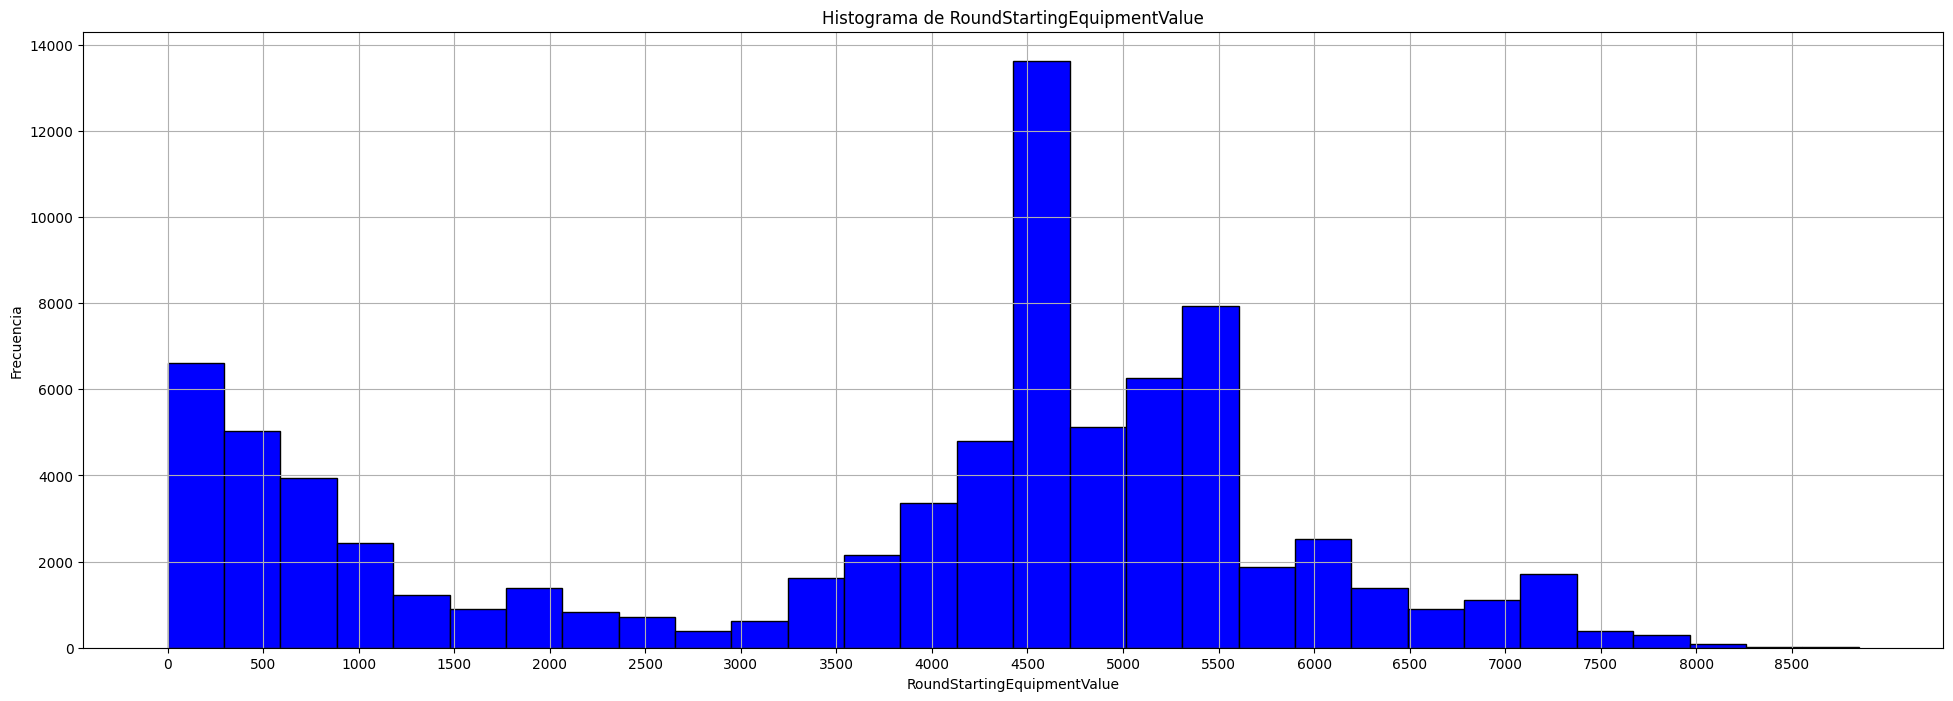

In [9]:
# Generar el histograma
plt.figure(figsize=(24,8))  # Tamaño de la figura
plt.hist(data['RoundStartingEquipmentValue'], bins=30, color='blue', edgecolor='black')  # Histograma

plt.xticks(np.arange(0, data['RoundStartingEquipmentValue'].max() + 1, 500))

plt.title('Histograma de RoundStartingEquipmentValue')  # Título del gráfico
plt.xlabel('RoundStartingEquipmentValue')  # Etiqueta del eje X
plt.ylabel('Frecuencia')  # Etiqueta del eje Y
plt.grid(True)  # Mostrar cuadrícula
plt.show()  # Mostrar el gráfico

A pesar de que la media (3778.11) es menor que la mediana (4700), lo que normalmente indicaría un sesgo negativo hacia la izquierda, sin embargo, el histograma de RoundStartingEquipmentValue muestra una distribución bimodal con dos picos claros: uno cerca de 0 y otro alrededor de 4500. Esto sugiere que los datos no están sesgados de la forma habitual, sino que se distribuyen en torno a dos concentraciones principales. Estas dos concentraciones podrían implicar diferentes estrategias de equipamiento en las rondas de juego.

### Correlación entre la variable objetivo y el resto

Aquí se calcula la correlación de las variables del data set con nuestra variable objetivo, para así poder determinar las variables más idóneas para nuestros modelos.

In [10]:
# Calcular la correlación entre todas las variables y RoundStartingEquipmentValue

columnas = ['InternalTeamId', 'MatchId', 'RoundId',
       'SteamId', 'RoundWinner', 'MatchWinner', 'Survived', 'AbnormalMatch',
       'TimeAlive', 'ScaledTimeAlive', 'AvgCentroidDistance',
       'TravelledDistance', 'AvgRoundVelocity', 'AvgKillDistance',
       'AvgSiteDistance', 'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown',
       'PrimaryAssaultRifle', 'PrimarySniperRifle', 'PrimaryHeavy',
       'PrimarySMG', 'PrimaryPistol', 'FirstKillTime', 'RoundKills',
       'RoundAssists', 'RoundHeadshots', 'RoundFlankKills',
       'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue',
       'MatchKills', 'MatchFlankKills', 'MatchAssists', 'MatchHeadshots',
       'AvgMatchKillDist']

data_select = data[columnas]

# Calcula la matriz de correlación
correlation_matrix = data_select.corr()

# Selecciona la correlación con RoundStartingEquipmentValue
round_eq_value_correlations = correlation_matrix["RoundStartingEquipmentValue"]

# Convertir la correlación en un DataFrame para poder manipular el formato
correlations_df = round_eq_value_correlations.reset_index()
correlations_df.columns = ['Variable', 'Correlación']

# Mostrar el resultado en 2 columnas
print(correlations_df.to_string(index=False, col_space=20, justify='justify'))

                   Variable          Correlación
             InternalTeamId             0.067674
                    MatchId             0.013234
                    RoundId             0.117606
                    SteamId            -0.021568
                RoundWinner            -0.302573
                MatchWinner            -0.175747
                   Survived             0.170578
              AbnormalMatch                  NaN
                  TimeAlive             0.104325
            ScaledTimeAlive             0.077456
        AvgCentroidDistance             0.148527
          TravelledDistance            -0.018644
           AvgRoundVelocity            -0.041877
            AvgKillDistance             0.167371
            AvgSiteDistance            -0.135498
      RLethalGrenadesThrown             0.438817
   RNonLethalGrenadesThrown             0.368180
        PrimaryAssaultRifle             0.518780
         PrimarySniperRifle             0.334221
               Prima

### Selección de las variables con mejor correlación

El siguiente bloque selecciona la mejor correlación de las variables del data set, tanto positivas como negativas.

In [11]:
round_correlations = correlation_matrix["RoundStartingEquipmentValue"]

sorted_correlations = round_correlations.sort_values(ascending=False)

# Obtener las 6 mayores correlaciones positivas (excluyendo la autocorrelación de TimeAlive consigo mismo)
top_6_positive = sorted_correlations[1:8]

# Obtener las 6 mayores correlaciones negativas
top_6_negative = sorted_correlations[-7:]

# Mostrar resultados
# Mostrar resultados
print("Top 6 correlaciones positivas:")
print(top_6_positive)

print("\nTop 6 correlaciones negativas:")
print(top_6_negative)

Top 6 correlaciones positivas:
TeamStartingEquipmentValue    0.922943
PrimaryAssaultRifle           0.518780
RLethalGrenadesThrown         0.438817
RNonLethalGrenadesThrown      0.368180
PrimarySniperRifle            0.334221
MatchKills                    0.179080
RoundKills                    0.172141
Name: RoundStartingEquipmentValue, dtype: float64

Top 6 correlaciones negativas:
PrimaryHeavy       -0.037131
AvgRoundVelocity   -0.041877
AvgSiteDistance    -0.135498
MatchWinner        -0.175747
RoundWinner        -0.302573
PrimaryPistol      -0.792876
AbnormalMatch            NaN
Name: RoundStartingEquipmentValue, dtype: float64


### Selección de variables numericas

Como se puede observar, no existe mucha correlación entre nuestra variable objetivo "RoundStartingEquipmentValue" y el resto de las variables, lo cual podría afectar al aprendizaje del modelo. De las 12 variables con mayor correlación positiva y negativa, se decidió escoger las siguientes:

- PrimaryAssaultRifle: Esta variable es importante porque los jugadores que usan rifles de asalto suelen gastar más en equipamiento al inicio de las rondas. Además, los rifles de asalto son armas muy comunes, lo que refleja una inversión significativa y una estrategia habitual en el juego.

- RLethalGrenadesThrown: La cantidad de granadas letales lanzadas está directamente relacionada con el valor de equipamiento, ya que los jugadores deben comprarlas antes de cada ronda. Cuantas más granadas se lancen, mayor fue la inversión en ellas.

Otra de las razones de que estas variables fueran escogidas es debido a que son las que tiene una mayor correlación con respecto al resto. Sin embargo, a pesar de que TeamStartingEquipmentValue tiene una mayor correlación, se decidió no utilizarla debido a que esta es la suma de los equipamientos de nuestra variable objetivo, por lo que incluirla sería redundante. 

### Verificación valores negativos

In [6]:
df_numericas = data[['PrimaryAssaultRifle', 'RLethalGrenadesThrown']]

df_numericas.min()

PrimaryAssaultRifle      0.0
RLethalGrenadesThrown    0.0
dtype: float64

En esta ocasión no hay valores negativos por lo que no sera necesario tratarlo.

### Verificación valores nulos

A continuación, se realizará un conteo de nulos de todas las características del data set para ver si es necesario un tratamiento en las fases posteriores.

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79157 entries, 0 to 79156
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   79157 non-null  int64  
 1   Map                          79157 non-null  object 
 2   Team                         79157 non-null  object 
 3   InternalTeamId               79157 non-null  int64  
 4   MatchId                      79157 non-null  int64  
 5   RoundId                      79157 non-null  int64  
 6   SteamId                      79157 non-null  int64  
 7   RoundWinner                  79157 non-null  bool   
 8   MatchWinner                  79157 non-null  bool   
 9   Survived                     79157 non-null  bool   
 10  AbnormalMatch                79157 non-null  bool   
 11  TimeAlive                    79157 non-null  float64
 12  ScaledTimeAlive              79157 non-null  float64
 13  AvgCentroidDista

Como se puede observar, no es necesario realizar un tratamiento, ya que no existen valores nulos en el conjunto de datos.

# Fase 3: Preparación De Los Datos

Al no tener valores nulos en las columnas, en esta fase se procederá a hacer la codificación de las variables categóricas para poder analizarlas y escoger cuáles se adaptan mejor para nuestro estudio.

### Transformación de la variable categórica (Target Encoding)

En esta ocasión, se decidió utilizar Target Encoder porque no incrementa la dimensionalidad del conjunto de datos, dado que una de nuestras variables categóricas (Map) cuenta con diversas categorías. Esto beneficia el rendimiento del modelo al evitar cargas innecesarias. Además, el Target Encoder mejora la correlación con la variable objetivo al codificar las variables categóricas en función del promedio de esta. Aunque existe el riesgo de sobreajuste, si se implementa correctamente, el Target Encoder puede ser muy beneficioso para optimizar el rendimiento del modelo.

Generación de una copia del dataframe original, en el cual se van a reemplazar las variables categóricas transformadas con la transformación del Target Encoding.

In [13]:
df_encoded = data.copy()

In [14]:
# Obtiene las columnas a codificar
categorical_features = df_encoded.describe(include = np.object_).columns
categorical_features

Index(['Map', 'Team'], dtype='object')

En esta ocasión, solo hay 2 variables categóricas que necesitan transformación. Aunque existen más variables categóricas en el conjunto de datos, estas son booleanas y no requieren transformación

Aplicación del Target Encoding

In [16]:
# Calcula el promedio de la variable objetivo (Precio) por cada columna
for feature in categorical_features:
  mean_encoded = df_encoded.groupby(feature)['RoundStartingEquipmentValue'].mean()

  # Asigna este promedio a la columna codificada en el DataFrame
  df_encoded[f'{feature}'] = df_encoded[feature].map(mean_encoded)


Verificación de la transformación

In [17]:
df_encoded.head(5)

,Unnamed: 0,Map,Team,InternalTeamId,MatchId,RoundId,SteamId,RoundWinner,MatchWinner,Survived,...,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,AvgMatchKillDist
0,600,3811.060307,3382.362599,1,4,1,76561198036987787,False,True,False,...,0,0,0,750,4400,0,0,0,0,501379.183091
1,601,3811.060307,3382.362599,1,4,1,76561197971812216,False,True,False,...,0,0,0,800,4400,0,0,0,0,208807.587297
2,602,3811.060307,3382.362599,1,4,1,76561197972240652,False,True,False,...,0,0,0,1000,4400,0,0,0,0,381652.027911
3,603,3811.060307,3382.362599,1,4,1,76561197975824962,False,True,False,...,0,0,0,850,4400,0,0,0,0,289754.503091
4,604,3811.060307,3382.362599,1,4,1,76561197960331095,False,True,True,...,0,0,0,1000,4400,0,0,0,0,254527.691176


Con las variables categóricas ya codificadas, ahora se calculará la correlación de todas ellas con nuestra variable objetivo.

In [18]:
# Calcular la correlación entre todas las variables categoricas y RoundStartingEquipmentValue

columnas = ['Map', 'Team', 'RoundWinner', 'MatchWinner', 'Survived', 'AbnormalMatch','RoundStartingEquipmentValue']

data_select = df_encoded[columnas]

correlation_matrix = data_select.corr()  # Calcula la matriz de correlación para todas las variables
timealive_correlations = correlation_matrix["RoundStartingEquipmentValue"]  # Seleccionar la correlación con TimeAlive

# Mostrar las correlaciones de todas las variables con TimeAlive
print(timealive_correlations)

Map                            0.013676
Team                           0.187508
RoundWinner                   -0.302573
MatchWinner                   -0.175747
Survived                       0.170578
AbnormalMatch                       NaN
RoundStartingEquipmentValue    1.000000
Name: RoundStartingEquipmentValue, dtype: float64


## Selección de variable categorica

La variable con mejor correlación es RoundWinner, con un valor de -0.302573, que si bien es considerada una correlación negativa, es la más alta que se tiene. Esto podría deberse a que los jugadores que ganan rondas no siempre comienzan con el mejor equipamiento, dando a entender la importancia de las dinámicas del juego y las estrategias de los jugadores. Debido a esto será utilizada en el estudio.

### Verificación de valores negativos variable categórica

In [10]:
min = data['RoundStartingEquipmentValue'].min()
print(f"El valor minimo de RoundStartingEquipmentValue es: {min}")

El valor minimo de RoundStartingEquipmentValue es: 0


En esta ocasión no hay valores negativos por lo que no sera necesario tratarlo.

# Fase 4: Modelamiento

En esta fase se realizar el entrenamiento de diversos modelos utilizando 2 variantes de variables.

Definición los distintos modelos a entrenar con variantes en sus hiperparámetros para las 2 alternativas.

In [48]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=29),
    'Random Forest': RandomForestRegressor(random_state=29),
    'Random Forest II': RandomForestRegressor(max_depth=5,random_state=29),
    'Random Forest III': RandomForestRegressor( max_depth=8,min_samples_leaf=6,  random_state=29),
}

### Entrenamiento modelos - Alternativa 1 (Sin variable categórica)

Se procederá a separar los datos de entrenamiento y testing, utilizando un 80% para entrenamiento y un 20% para testing.

In [49]:
# Divide en conjunto de características (X) y variable objetivo (y)
X = pd.DataFrame(data[['PrimaryAssaultRifle','RLethalGrenadesThrown']])
y = data['RoundStartingEquipmentValue']  # La variable objetivo

# Divide en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

In [21]:
print(f"{'Shape del set de entrenamiento':<30}:", X_train.shape)
print(f"{'Shape del set de prueba':<30}:", X_test.shape)

Shape del set de entrenamiento: (63325, 2)
Shape del set de prueba       : (15832, 2)


A continuación, se realizará el entrenamiento de todos los modelos utilizando únicamente las variables numéricas, recorriéndolos mediante un ciclo for para el entrenamiento y testing.

In [50]:
# Diccionario para guardar los modelos entrenados
trained_models_s = {}
history_s = {}

# Entrenar y evaluar los modelos
for name, model in models.items():
    pipeline = Pipeline(steps=[('model', model)])
    pipeline.fit(X_train, y_train)
    
    # Guardar el modelo entrenado en el diccionario para usarlo después
    trained_models_s[name] = pipeline
    
    # Hacer predicciones y calcular métricas
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    msle = mean_squared_log_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    score_train = model.score(X_train, y_train)
    
    print(f'{name:<20} - MAE: {mae:.2f} - MSLE: {msle:.4f} - R² test: {r2:.4f} - R² train: {score_train:.4f}')
    
    # Guardar los resultados en el diccionario de historial
    history_s[name] = [pipeline.named_steps['model'], pipeline.named_steps['model'].score(X_test, y_test), score_train, mae, msle]


Linear Regression    - MAE: 1205.87 - MSLE: 0.9843 - R² test: 0.3599 - R² train: 0.3479
Decision Tree        - MAE: 1083.55 - MSLE: 0.8693 - R² test: 0.4094 - R² train: 0.4604
Random Forest        - MAE: 1072.80 - MSLE: 0.8517 - R² test: 0.4256 - R² train: 0.4543
Random Forest II     - MAE: 1062.00 - MSLE: 0.8487 - R² test: 0.4379 - R² train: 0.4311
Random Forest III    - MAE: 1061.96 - MSLE: 0.8487 - R² test: 0.4372 - R² train: 0.4334


### Entrenamiento modelos - Alternativa 2 (Con variable categórica)

Se dividirán los datos para entrenamiento y pruebas, incluyendo la variable categórica RoundWinner. Se utilizará un 80% de los datos para el entrenamiento y un 20% para las pruebas.

In [78]:
# Divide en conjunto de características (X) y variable objetivo (y)
Xc = pd.DataFrame(df_encoded[['PrimaryAssaultRifle','RLethalGrenadesThrown','RoundWinner']])
yc = df_encoded['RoundStartingEquipmentValue']  # La variable objetivo

# Divide en conjunto de entrenamiento y prueba
X_trainc, X_testc, y_trainc, y_testc = train_test_split(Xc, yc, test_size=0.2, random_state=29)

A continuación, se realizará el entrenamiento de todos los modelos mediante un ciclo for, considerando las 2 variables numéricas y 1 variable categórica.

In [88]:
# Diccionario para guardar los modelos entrenados
trained_models_c = {}
history_c = {}

# Entrenar y evaluar los modelos
for name, model in models.items():
    pipeline = Pipeline(steps=[('model', model)])
    pipeline.fit(X_trainc, y_trainc)
    
    # Guardar el modelo entrenado en el diccionario para usarlo después
    trained_models_c[name] = pipeline
    
    # Hacer predicciones y calcular métricas
    y_predc = pipeline.predict(X_testc)
    mae = mean_absolute_error(y_testc, y_predc)
    msle = mean_squared_log_error(y_testc, y_predc)
    r2 = r2_score(y_testc, y_predc)
    score_train = model.score(X_trainc, y_trainc)
    
    print(f'{name:<20} - MAE: {mae:.2f} - MSLE: {msle:.4f} - R² test: {r2:.4f} - R² train: {score_train:.4f}')
    
    # Guardar los resultados en el diccionario de historial
    history_c[name] = [pipeline.named_steps['model'], pipeline.named_steps['model'].score(X_testc, y_testc), score_train, mae, msle]


Linear Regression    - MAE: 1196.38 - MSLE: 0.9392 - R² test: 0.3851 - R² train: 0.3720
Decision Tree        - MAE: 1047.20 - MSLE: 0.7839 - R² test: 0.4425 - R² train: 0.4917
Random Forest        - MAE: 1037.38 - MSLE: 0.7691 - R² test: 0.4589 - R² train: 0.4858
Random Forest II     - MAE: 1028.12 - MSLE: 0.7664 - R² test: 0.4706 - R² train: 0.4620
Random Forest III    - MAE: 1027.11 - MSLE: 0.7663 - R² test: 0.4701 - R² train: 0.4650


# Fase 5: Evaluación

En esta fase, se evaluarán los modelos entrenados y se seleccionará el mejor para cada alternativa.

### Resultados de entrenamiento de la alternativa 1 (sin variable categórica)

In [89]:
for modelo, resultados in history_s.items():
    print("\n")
    print(f"Modelo: {modelo}")
    mae = resultados[3]  # MAE está en la posición 2
    msle = resultados[4]  # MSLE está en la posición 3
    

    # Llamando a las funciones con los datos correspondientes
    mae_interpretacion(modelo, mae)
    msle_interpretacion(modelo, msle)



Modelo: Linear Regression
Interpretación del MAE: 1205.8664038237948
El modelo 'Linear Regression' pudo predecir el valor del equipamiento del jugador en el conjunto de prueba con un error de ± $ 1205.87 del valor real.
Interpretación del MSLE: 0.9843243364874016
El modelo 'Linear Regression' pudo predecir el valor del equipamiento del jugador en el conjunto de prueba con un error de ±  98.43% del valor real.


Modelo: Decision Tree
Interpretación del MAE: 1083.551709662569
El modelo 'Decision Tree' pudo predecir el valor del equipamiento del jugador en el conjunto de prueba con un error de ± $ 1083.55 del valor real.
Interpretación del MSLE: 0.8692503496056961
El modelo 'Decision Tree' pudo predecir el valor del equipamiento del jugador en el conjunto de prueba con un error de ±  86.93% del valor real.


Modelo: Random Forest
Interpretación del MAE: 1072.7951793890875
El modelo 'Random Forest' pudo predecir el valor del equipamiento del jugador en el conjunto de prueba con un error 

### Interpretación y mejor modelo sin variable categoria

Respecto al Error Absoluto Medio (MAE) y al Error Cuadrático Logarítmico Medio (MSLE), se puede observar que el modelo Linear Regression es el que presenta valores más altos, con un MAE de 1205.87 y un MSLE de 0.9843, indicando un mayor nivel de error en sus predicciones. En cambio, los modelos basados en árboles de decisión muestran un mejor desempeño, aunque no con una diferencia significativa. Y de todos los modelos el que obtuvo menor error fue el Random Forest III.

En cuanto al coeficiente de determinación (R²), ninguno de los modelos supera el 50% en el conjunto de pruebas. El valor más alto se encuentra en el modelo Random Forest III, con un R² test de 0.4372. Lo que sugiere que este modelo logra capturar una proporción razonable de la variabilidad en los datos. A pesar de esto, el modelo no presenta sobreajuste considerable, dado que la diferencia del R² entre entrenamiento y pruebas es mínima.

Por lo tanto, el mejor modelo sin categoría sería el Random Forest III, con los siguientes datos:

MAE: 1061.96
MSLE: 0.8487
R² test: 0.4372
R² train: 0.4334

## Resultados de entrenamiento de la alternativa 2 (con variable categórica)

In [90]:
for modelo, resultados in history_c.items():
    print("\n")
    print(f"Modelo: {modelo}")
    mae = resultados[3]  # MAE está en la posición 2
    msle = resultados[4]  # MSLE está en la posición 3
    

    # Llamando a las funciones con los datos correspondientes
    mae_interpretacion(modelo, mae)
    msle_interpretacion(modelo, msle)



Modelo: Linear Regression
Interpretación del MAE: 1196.384467214462
El modelo 'Linear Regression' pudo predecir el valor del equipamiento del jugador en el conjunto de prueba con un error de ± $ 1196.38 del valor real.
Interpretación del MSLE: 0.9391979486624474
El modelo 'Linear Regression' pudo predecir el valor del equipamiento del jugador en el conjunto de prueba con un error de ±  93.92% del valor real.


Modelo: Decision Tree
Interpretación del MAE: 1047.1999190945257
El modelo 'Decision Tree' pudo predecir el valor del equipamiento del jugador en el conjunto de prueba con un error de ± $ 1047.20 del valor real.
Interpretación del MSLE: 0.7839499132329832
El modelo 'Decision Tree' pudo predecir el valor del equipamiento del jugador en el conjunto de prueba con un error de ±  78.39% del valor real.


Modelo: Random Forest
Interpretación del MAE: 1037.3841827623526
El modelo 'Random Forest' pudo predecir el valor del equipamiento del jugador en el conjunto de prueba con un error 

### Interpretación y mejor modelo con variable categoria

Al analizar el MAE y el MSLE, se destaca el modelo Linear Regression por tener los valores más altos en ambos apartados, con un MAE de 1196.38 y un MSLE de 0.9392. Por otro lado, los modelos basados en árboles de decisión muestran un mejor rendimiento. De todos los modelos sobresale el Random Forest III con un MAE de 1027.11 y un MSLE de 0.7663 teniendo un menor nivel de error en las predicciones con respecto al resto.

En cuanto al R², al igual que en los modelos de la alternativa 1, ninguno supera el 50% en el conjunto de pruebas. Destacando de entre todos el modelo Random Forest III, con un R² de 0.4701, lo que indica que captura una proporción razonable de la variabilidad en los datos. Aunque este valor no es el más idóneo, puede deberse a la baja correlación entre las variables en este conjunto de datos. A pesar de esto, el modelo no presenta sobreajuste considerable, ya que la diferencia del R² entre entrenamiento y pruebas es baja.

Por lo tanto, el mejor modelo con categoría sería el Random Forest III, cuyos datos son los siguientes:

MAE: 1027.11
MSLE: 0.7663
R² test: 0.4701
R² train: 0.4650

# Fase 6: Deployment

## Alternativa 1

Para la carga de este JSON se tomaron en cuenta las siguientes variables independientes.

- RLethalGrenadesThrown.

- PrimaryAssaultRifle.

De la lista de modelos almacenados se extrae el mejor y se almacena en un archivo pkl.

In [64]:
model_alt_1 = trained_models_s['Random Forest III']

In [65]:
with open('model_alt_1.pkl', 'wb') as f:
    pickle.dump(model_alt_1, f)

print("Modelo 'model_alt_1.pkl' guardado.")

Modelo 'model_alt_1.pkl' guardado.


## Alternativa 2

Para la carga de este JSON se tomaron en cuenta las siguientes variables independientes.

- RLethalGrenadesThrown

- PrimaryAssaultRifle

- RoundWinner

De la lista de modelos almacenados se extrae el mejor y se almacena en un archivo pkl.

In [93]:
model_alt_2 = trained_models_s['Random Forest III']

In [94]:
with open('model_alt_2.pkl', 'wb') as f:
    pickle.dump(model_alt_2, f)

print("Modelo 'model_alt_2.pkl' guardado.")

Modelo 'model_alt_2.pkl' guardado.


# Pregunta final

### ¿Qué modelo recomendaría utilizar para cumplir con el objetivo propuesto al inicio? 

En base al análisis que hemos realizado y considerando el objetivo de estimar el valor del equipamiento de los jugadores por ronda, el mejor de nuestros modelos es el Random Forest III de la alternativa 2 considerando variable categórica. Este modelo demostró tener un mejor desempeño en todos los apartados (MAE, MSLE Y R²) en comparación al resto, sin embargo, el porcentaje de R2 en este caso no es recomendable para implementación (0.47 aproximadamente), pero aún existe un margen de mejora, por lo que se recomienda aplicar ciertas mejoras en próximas iteraciones, tal vez en la fase 3 con el tratamiento de datos para obtener unos mejores resultados.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=374e4780-ce75-42fd-ab0d-846b9d5716fe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>